In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from tqdm import tqdm

# Load data

In [3]:
def bootstrapped(data,n_resamples = 20):
    data = (data,)
    bootstrap_ci = scipy.stats.bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return np.abs(bootstrap_ci.confidence_interval[1] - np.mean(data))

In [4]:
def set_fig_(ax , xlabel=0, ylabel=0 , xlog=0, ylog=0, fontsize=16, iflegend=0 , ncol=1, legendloc=2,color = 'k'):
    if xlabel!=0:
        ax.set_xlabel(xlabel,size = fontsize)
    else:
        ax.set_xlabel('')
    if ylabel!=0:
        ax.set_ylabel(ylabel,size = fontsize,color =color)
    else:
        ax.set_ylabel('')
    if ylog:
        ax.set_yscale("log")
    if xlog:
        ax.set_xscale("log")
    if iflegend==1:
        ax.legend(frameon =False,fontsize = 14, loc=legendloc)
    if iflegend==2:
        ax.legend(frameon =False,fontsize = fontsize,ncol=ncol,bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14,labelcolor =color)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)

In [5]:
df = pd.read_csv(r"E:\Data\Patent\KPSS\TextInnovation.csv.zip")
df['KI5'] = np.log(df['fsim5']/df['bsim5'])
for col in ['bsim5', 'fsim1', 'fsim5','fsim10', 'np_b5', 'np_f1', 'np_f5', 'np_f10']:
    del df[col]
df = df[df['filed_year'].isin(range(1980,2018))].reset_index(drop=True)

cd = pd.read_csv(r"E:\Data\Patent\KPSS\citations\Disruption.csv.zip")
cd['CD1'] = (cd['D1']-cd['C1'])/(cd['D1']+cd['C1']+cd['R1'])
df['CD1'] = df['patent_id'].map(cd.set_index('patent_id')['CD1'])

cd['CD5'] = (cd['D5']-cd['C5'])/(cd['D5']+cd['C5']+cd['R5'])
df['CD5'] = df['patent_id'].map(cd.set_index('patent_id')['CD5'])

In [6]:
cit = pd.read_csv(r"E:\Data\Patent\KPSS\citations\CitationWindows.csv.zip")

df['Cit5'] = df['patent_id'].map(cit.set_index('patent_id')['cit5'])
df['Cit5'] = df['Cit5'].fillna(0)

df['Cit10'] = df['patent_id'].map(cit.set_index('patent_id')['cit10'])
df['Cit10'] = df['Cit10'].fillna(0)

df['Cit'] = df['patent_id'].map(cit.set_index('patent_id')['cit'])
df['Cit'] = df['Cit'].fillna(0)

# Citation

In [7]:
df['CD5_'] = df['CD5'].map(lambda x:np.round(x,1))
df['KI5_'] = df['KI5'].map(lambda x:np.round(x,1))

df.loc[df['KI5_']>1 , 'KI5_'] = 1
df.loc[df['KI5_']<-1 , 'KI5_'] = -1

In [8]:
d1 = df.groupby('KI5_')['Cit5'].mean().reset_index()
ci1 = df.dropna(subset=['KI5_','Cit5']).groupby('KI5_')['Cit5'].apply(bootstrapped).reset_index()

d2 = df.groupby('CD5_')['Cit5'].mean().reset_index()
ci2 = df.dropna(subset=['CD5_','Cit5']).groupby('CD5_')['Cit5'].apply(bootstrapped).reset_index()

d1_ = df.groupby('KI5_')['Cit10'].mean().reset_index()
ci1_ = df.dropna(subset=['KI5_','Cit10']).groupby('KI5_')['Cit10'].apply(bootstrapped).reset_index()

d2_ = df.groupby('CD5_')['Cit10'].mean().reset_index()
ci2_ = df.dropna(subset=['CD5_','Cit10']).groupby('CD5_')['Cit10'].apply(bootstrapped).reset_index()

In [9]:
CPC = pd.read_csv(r"E:\Data\Patent\Patent\Field\cpc.csv.zip")
CPC1 = CPC[['patent_id','cpc_section']].drop_duplicates().reset_index(drop=True)

dfc = df.merge(CPC1,on='patent_id',how='left')
dfc.index = range(len(dfc))

#hit paper
hits10 = []
for (year,field),f in tqdm(dfc.groupby(['filed_year','cpc_section'])):
    if len(f)>9:
        f.sort_values('Cit' , inplace = True)
        hits10.extend(f['patent_id'].values[int(len(f)*0.9):])
Hits10 = pd.DataFrame({'patent_id':hits10 })
Hits10['Hits'] = 1
dfc['Hits10'] = dfc['patent_id'].map(Hits10.drop_duplicates(subset='patent_id').set_index('patent_id')['Hits'])
dfc['Hits10'] = dfc['Hits10'].fillna(0)

 91%|████████████████████████████████████████████████████████████████████████▏      | 342/374 [00:02<00:00, 142.56it/s]


In [12]:
d1__ = dfc.groupby('KI5_')['Hits10'].mean().reset_index()
d2__ = dfc.groupby('CD5_')['Hits10'].mean().reset_index()

In [ ]:
d1__['Hits10'] = d1__['Hits10']/dfc['Hits10'].mean()
d2__['Hits10'] = d2__['Hits10']/dfc['Hits10'].mean()

In [37]:
def draw_hist(df , col):
    ax_ = ax.twinx()
    hist, bin_edges = np.histogram(df[col].dropna().values, bins=20)
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the midpoints
    plt.bar(bin_mids-.05, hist, width=np.diff(bin_edges) , color = 'k' , alpha = .1)
    set_fig_(ax_, 0, 'N (patents)', 0, 0,color = 'grey')

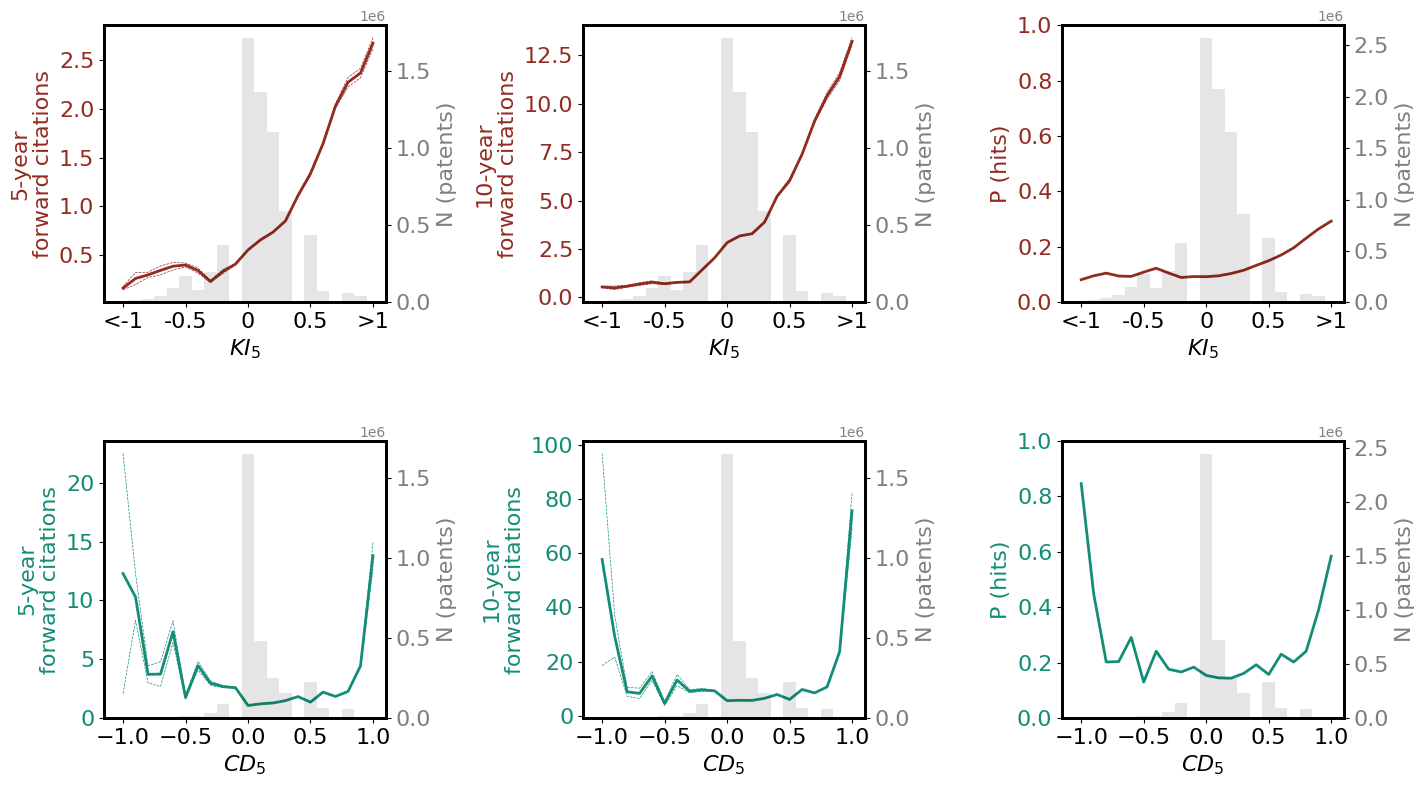

In [39]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

color='#922B21'
ax = fig.add_subplot(gs[0])
plt.plot(d1['KI5_'].values , d1['Cit5'].values , color=color , lw=2)
plt.plot(d1['KI5_'].values , d1['Cit5'].values+ci1['Cit5'].values , color=color, ls='--' , lw=.5)
plt.plot(d1['KI5_'].values , d1['Cit5'].values-ci1['Cit5'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$KI_5$', '5-year\nforward citations',color=color)
plt.xticks([-1,-.5,0,.5,1],['<-1',-.5,0,.5,'>1'])
draw_hist(df , 'KI5_')

ax = fig.add_subplot(gs[1])
plt.plot(d1_['KI5_'].values , d1_['Cit10'].values , color=color , lw=2)
plt.plot(d1_['KI5_'].values , d1_['Cit10'].values+ci1_['Cit10'].values , color=color, ls='--' , lw=.5)
plt.plot(d1_['KI5_'].values , d1_['Cit10'].values-ci1_['Cit10'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$KI_5$', '10-year\nforward citations',color=color)
plt.xticks([-1,-.5,0,.5,1],['<-1',-.5,0,.5,'>1'])
draw_hist(df , 'KI5_')

ax = fig.add_subplot(gs[2])
plt.plot(d1__['KI5_'].values , d1__['Hits10'].values , color=color , lw=2)
set_fig_(ax , '$KI_5$', 'P (hits)',color=color)
plt.ylim(0,1)
plt.xticks([-1,-.5,0,.5,1],['<-1',-.5,0,.5,'>1'])
draw_hist(dfc , 'KI5_')

color='#138D75'
ax = fig.add_subplot(gs[3])
plt.plot(d2['CD5_'].values , d2['Cit5'].values , color=color , lw=2)
plt.plot(d2['CD5_'].values , d2['Cit5'].values+ci2['Cit5'].values , color=color, ls='--' , lw=.5)
plt.plot(d2['CD5_'].values , d2['Cit5'].values-ci2['Cit5'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$CD_5$', '5-year\nforward citations',color=color)
plt.xticks([-1,-.5,0,.5,1])
draw_hist(df , 'CD5_')

ax = fig.add_subplot(gs[4])
plt.plot(d2_['CD5_'].values , d2_['Cit10'].values , color=color , lw=2)
plt.plot(d2_['CD5_'].values , d2_['Cit10'].values+ci2_['Cit10'].values , color=color, ls='--' , lw=.5)
plt.plot(d2_['CD5_'].values , d2_['Cit10'].values-ci2_['Cit10'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$CD_5$', '10-year\nforward citations',color=color)
plt.xticks([-1,-.5,0,.5,1])
draw_hist(df , 'CD5_')

ax = fig.add_subplot(gs[5])
plt.plot(d2__['CD5_'].values , d2__['Hits10'].values , color=color , lw=2)
set_fig_(ax , '$CD_5$', 'P (hits)',color=color)
plt.ylim(0,1)
plt.xticks([-1,-.5,0,.5,1])
draw_hist(dfc , 'CD5_')
plt.savefig(savepath + "Cit.svg",bbox_inches = 'tight')

# Appendix eco value

In [17]:
KPSS = pd.read_csv(r"E:\Data\Patent\KPSS\KPSS_2022.csv.zip")
df['xi_nominal'] = df['patent_id'].map(KPSS.set_index('patent_num')['xi_nominal'])
df['xi_real'] = df['patent_id'].map(KPSS.set_index('patent_num')['xi_real'])

In [41]:
d1__ = df.groupby('KI5_')['xi_real'].mean().reset_index()
ci1__ = df.dropna(subset=['KI5_','xi_real']).groupby('KI5_')['xi_real'].apply(bootstrapped).reset_index()

d2__ = df.groupby('CD5_')['xi_real'].mean().reset_index()
ci2__ = df.dropna(subset=['CD5_','xi_real']).groupby('CD5_')['xi_real'].apply(bootstrapped).reset_index()

d1___ = df.groupby('KI5_')['xi_nominal'].mean().reset_index()
ci1___ = df.dropna(subset=['KI5_','xi_nominal']).groupby('KI5_')['xi_nominal'].apply(bootstrapped).reset_index()

d2___ = df.groupby('CD5_')['xi_nominal'].mean().reset_index()
ci2___ = df.dropna(subset=['CD5_','xi_nominal']).groupby('CD5_')['xi_nominal'].apply(bootstrapped).reset_index()

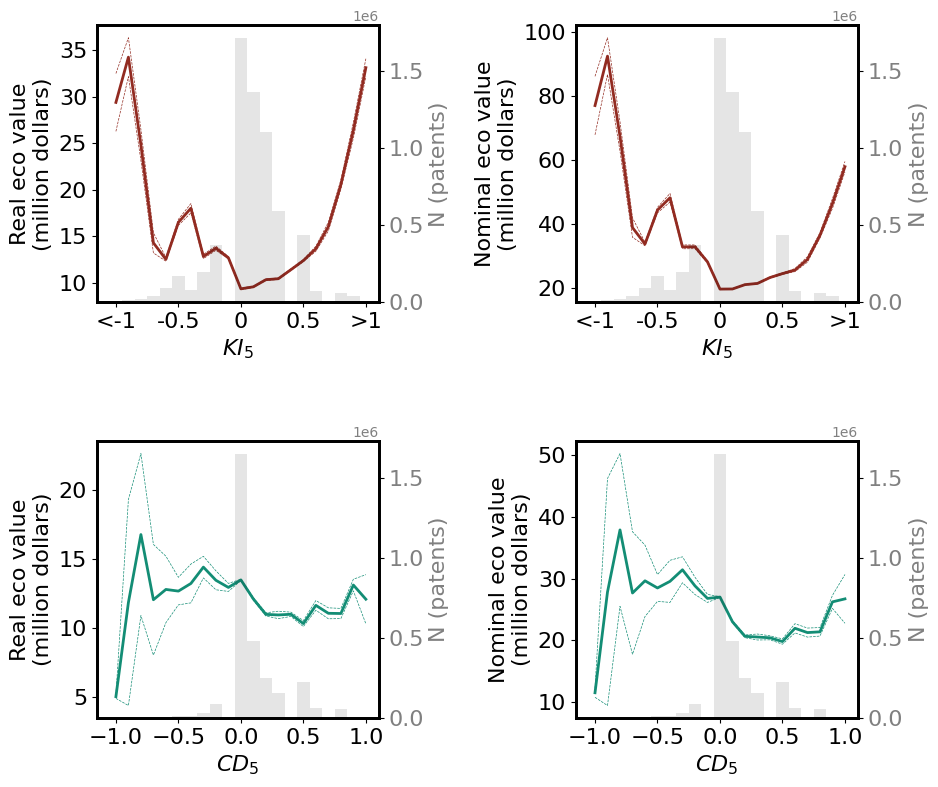

In [42]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.7,hspace=0.5)

color='#922B21'
ax = fig.add_subplot(gs[0])
plt.plot(d1__['KI5_'].values , d1__['xi_real'].values , color=color , lw=2)
plt.plot(d1__['KI5_'].values , d1__['xi_real'].values+ci1__['xi_real'].values , color=color, ls='--' , lw=.5)
plt.plot(d1__['KI5_'].values , d1__['xi_real'].values-ci1__['xi_real'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$KI_5$', 'Real eco value\n(million dollars)')
plt.xticks([-1,-.5,0,.5,1],['<-1',-.5,0,.5,'>1'])
draw_hist(df , 'KI5_')

ax = fig.add_subplot(gs[1])
plt.plot(d1___['KI5_'].values , d1___['xi_nominal'].values , color=color , lw=2)
plt.plot(d1___['KI5_'].values , d1___['xi_nominal'].values+ci1___['xi_nominal'].values , color=color, ls='--' , lw=.5)
plt.plot(d1___['KI5_'].values , d1___['xi_nominal'].values-ci1___['xi_nominal'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$KI_5$', 'Nominal eco value\n(million dollars)')
plt.xticks([-1,-.5,0,.5,1],['<-1',-.5,0,.5,'>1'])
draw_hist(df , 'KI5_')

color='#138D75'
ax = fig.add_subplot(gs[3])
plt.plot(d2__['CD5_'].values , d2__['xi_real'].values , color=color , lw=2)
plt.plot(d2__['CD5_'].values , d2__['xi_real'].values+ci2__['xi_real'].values , color=color, ls='--' , lw=.5)
plt.plot(d2__['CD5_'].values , d2__['xi_real'].values-ci2__['xi_real'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$CD_5$', 'Real eco value\n(million dollars)')
plt.xticks([-1,-.5,0,.5,1])
draw_hist(df , 'CD5_')

ax = fig.add_subplot(gs[4])
plt.plot(d2___['CD5_'].values , d2___['xi_nominal'].values , color=color , lw=2)
plt.plot(d2___['CD5_'].values , d2___['xi_nominal'].values+ci2___['xi_nominal'].values , color=color, ls='--' , lw=.5)
plt.plot(d2___['CD5_'].values , d2___['xi_nominal'].values-ci2___['xi_nominal'].values , color=color, ls='--' , lw=.5)
set_fig_(ax , '$CD_5$', 'Nominal eco value\n(million dollars)')
plt.xticks([-1,-.5,0,.5,1])
draw_hist(df , 'CD5_')

plt.savefig(savepath + "Eco.svg",bbox_inches = 'tight')